<a href="https://www.kaggle.com/code/sandanas/dog-breed?scriptVersionId=238819007" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#  **Data Preparation**

### Importing Libraries and Suppressing Warnings

In [2]:

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import os
import pandas as pd
from shutil import copyfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


2025-05-09 20:38:45.301118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 20:38:45.301245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-09 20:38:45.430640: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Setting Dataset Paths and Loading Labels


In [3]:


# Set the path to the dataset
train_dir = '/kaggle/input/dog-breed-identification/train'
labels_file = '/kaggle/input/dog-breed-identification/labels.csv'

# Load the labels
labels_df = pd.read_csv(labels_file)


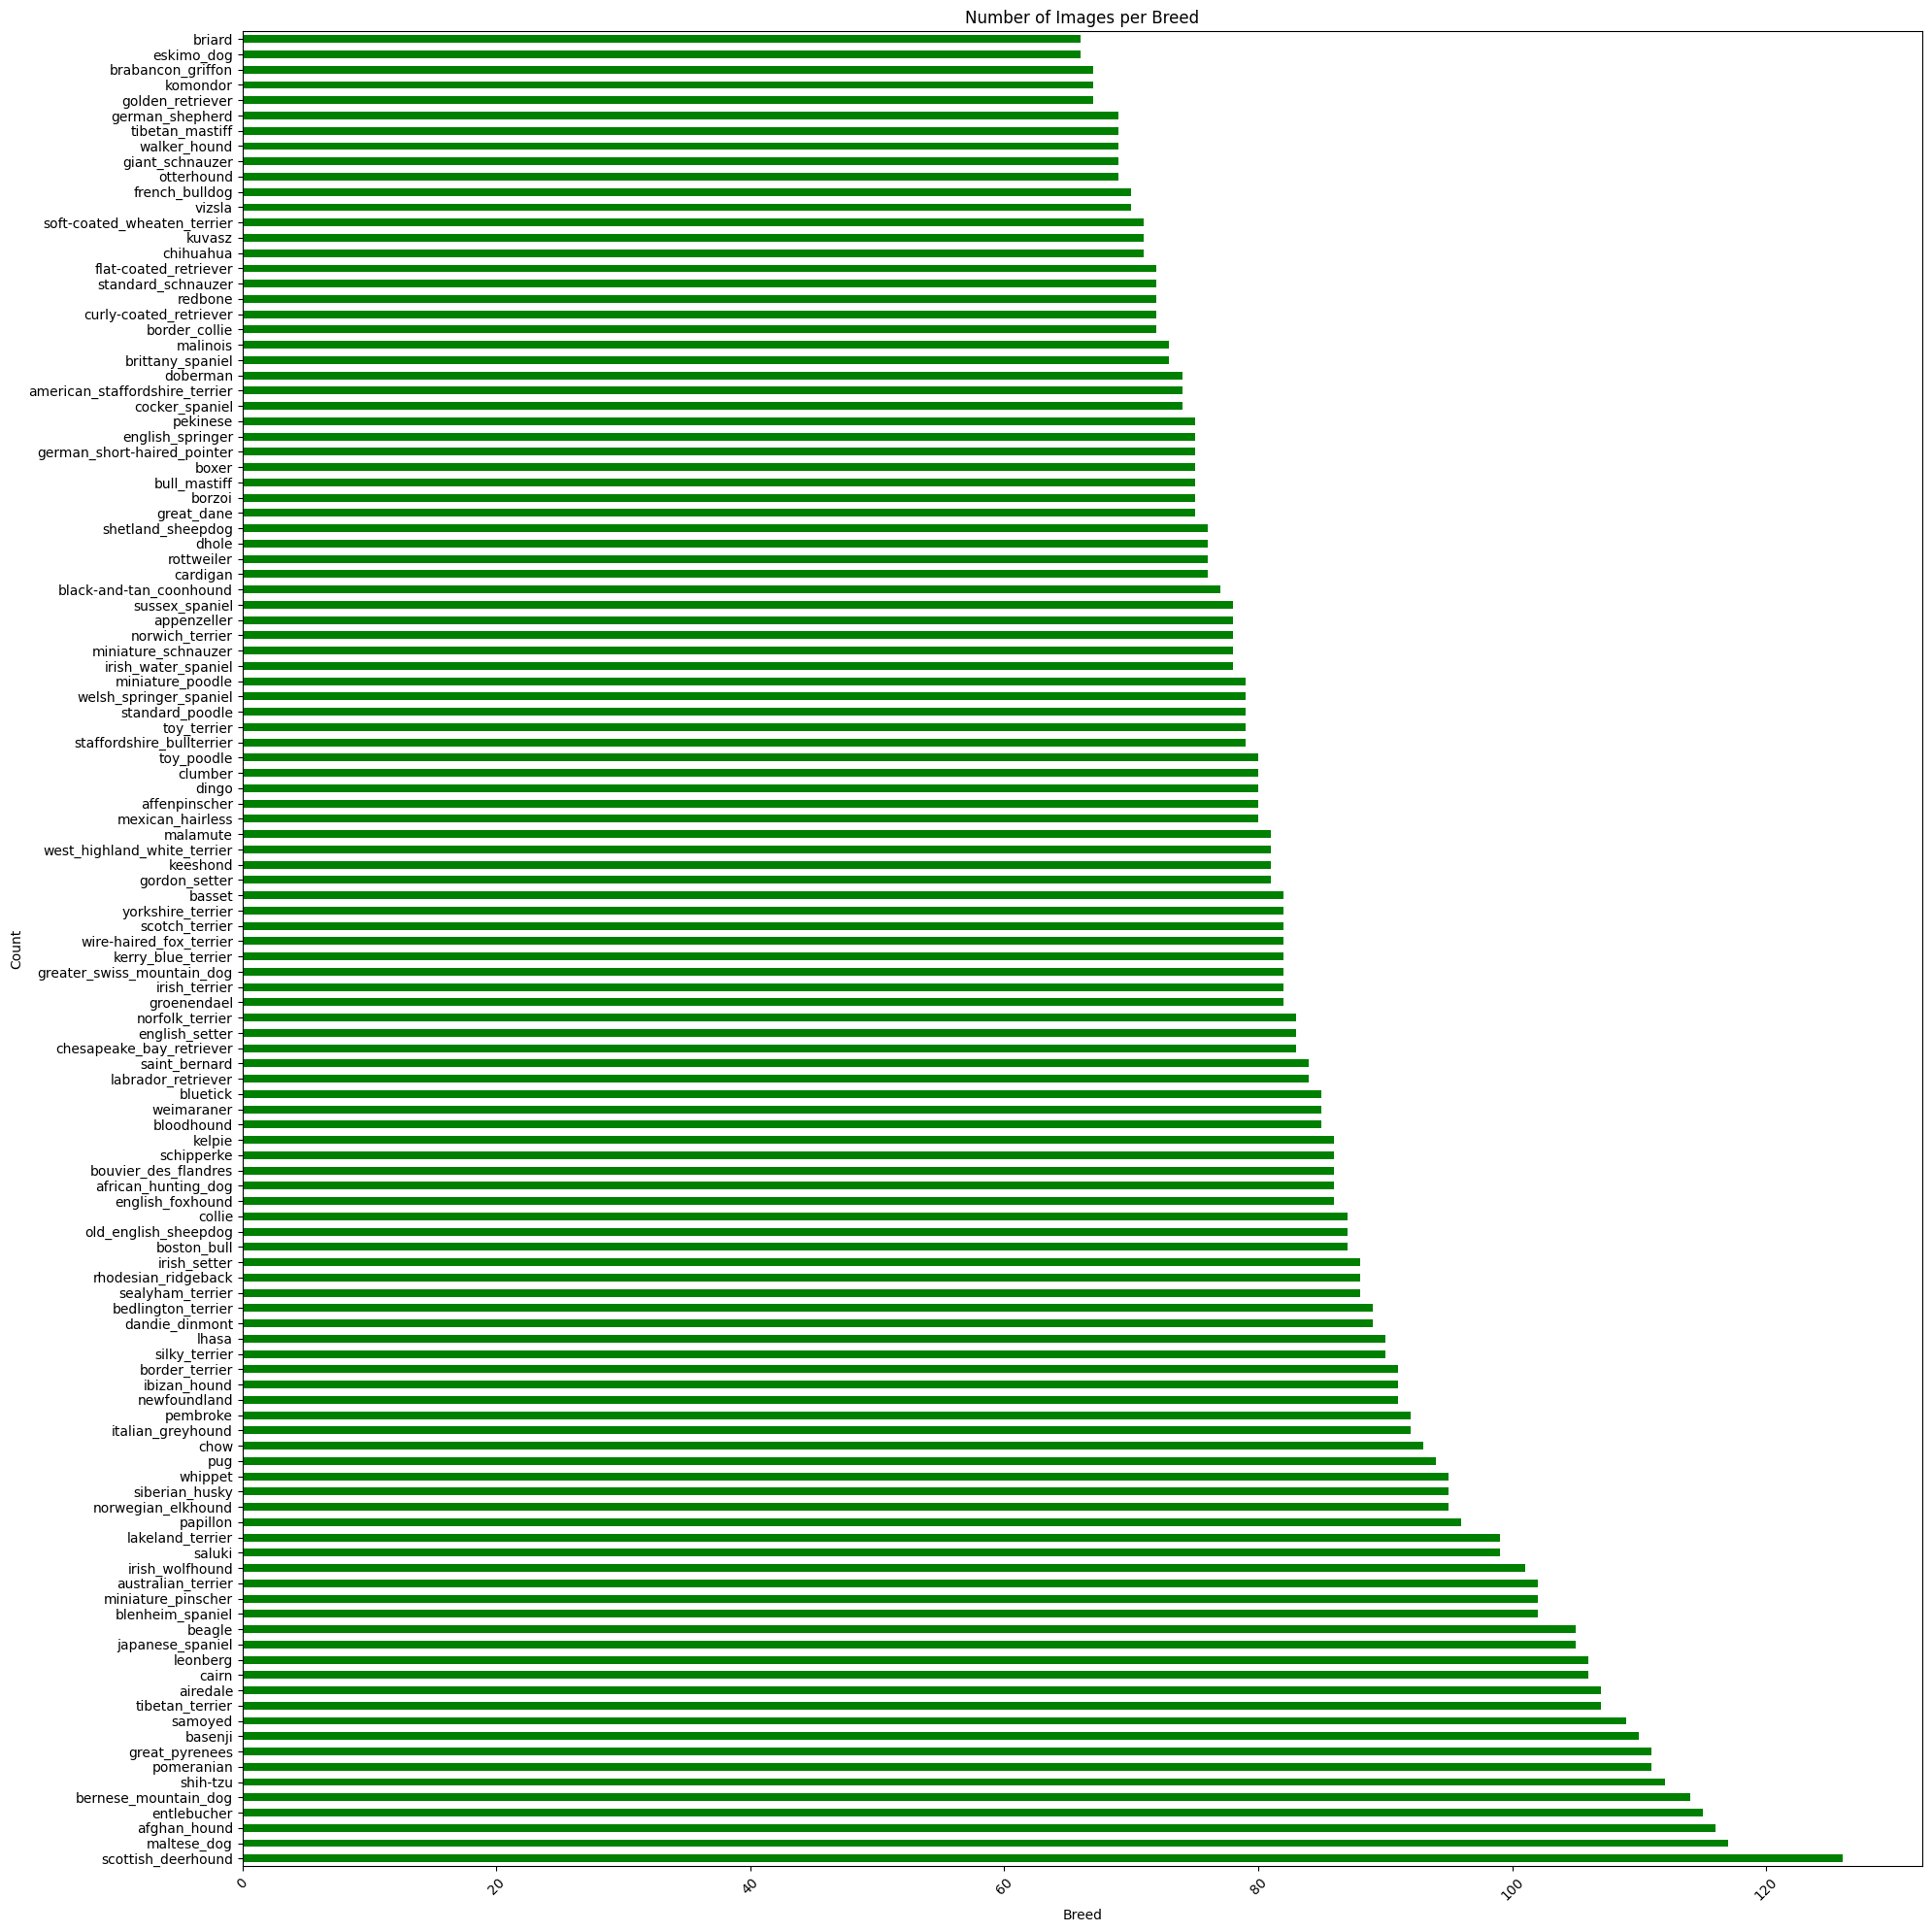

In [4]:
import matplotlib.pyplot as plt

# Count the number of images per breed
breed_counts = labels_df['breed'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(20, 20))
breed_counts.plot(kind='barh',color='g')
plt.title('Number of Images per Breed')
plt.xlabel('Breed')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Filtering for Top 10 Breeds and Ensuring Image Count


In [5]:


# Filter for 10 breeds with 100 images each
selected_breeds = labels_df['breed'].value_counts().nlargest(10).index
filtered_labels_df = labels_df[labels_df['breed'].isin(selected_breeds)]

# Ensure each breed has exactly 100 images
filtered_labels_df = filtered_labels_df.groupby('breed').head(100)

filtered_labels_df['id'] = filtered_labels_df['id'] + '.jpg'


#### Selected Breeds

In [6]:
selected_breeds_list = filtered_labels_df['breed'].unique()
for breed in selected_breeds_list:
    print(breed)



basenji
scottish_deerhound
maltese_dog
shih-tzu
samoyed
entlebucher
bernese_mountain_dog
afghan_hound
great_pyrenees
pomeranian


####  Creating Directory for Filtered Images and Copying


In [7]:

filtered_images_dir = '/kaggle/working/filtered_images'
os.makedirs(filtered_images_dir, exist_ok=True)

for img_name in filtered_labels_df['id']:
    src = os.path.join(train_dir, img_name)
    dst = os.path.join(filtered_images_dir, img_name)
    copyfile(src, dst)


#### Encoding Labels and Splitting Data


In [8]:


filtered_labels_df['breed'] = filtered_labels_df['breed'].astype('category')
filtered_labels_df['breed_code'] = filtered_labels_df['breed'].cat.codes
num_classes = filtered_labels_df['breed_code'].nunique()

train_df, val_df = train_test_split(
    filtered_labels_df, 
    test_size=0.2, 
    stratify=filtered_labels_df['breed_code'],
    random_state=42
)


####  Data Augmentation and Image Loading


In [9]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    validation_split=0.2 
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  


#### Generating Image Data for Training and Validation


In [10]:

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=filtered_images_dir,
    x_col='id',
    y_col='breed',
    subset='training', 
    batch_size=16,
    shuffle=True,
    class_mode='categorical',
    target_size=(128, 128)  
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=filtered_images_dir,
    x_col='id',
    y_col='breed',
    subset='validation',  
    batch_size=16,  
    shuffle=True,
    class_mode='categorical',
    target_size=(128, 128)  
)


Found 640 validated image filenames belonging to 10 classes.
Found 40 validated image filenames belonging to 10 classes.


#### Model Building and Training


In [11]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x) 
x = BatchNormalization()(x)  
x = Dropout(0.5)(x)  
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Compiling and Training the Model

In [12]:
for layer in base_model.layers[-40:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)


Epoch 1/50
 3/40 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.0417 - loss: 15.5574      

I0000 00:00:1746823196.737002      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 59s 251ms/step - accuracy: 0.1235 - loss: 14.7045 - val_accuracy: 0.6250 - val_loss: 12.4917 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.4178 - loss: 12.9863 - val_accuracy: 0.7500 - val_loss: 11.9753 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.5578 - loss: 12.5199 - val_accuracy: 0.8000 - val_loss: 11.8398 - learning_rate: 1.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.6459 - loss: 12.1812 - val_accuracy: 0.7750 - val_loss: 11.7853 - learning_rate: 1.0000e-04
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.6965 - loss: 11.7831 - val_accuracy: 0.8250 - val_loss: 11.6188 - learning_rate: 1.0000e-04
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.7089 - loss: 11.6243 - val_accuracy: 0.8500 - val_loss: 11.4720 - learning_rate: 1.0000e-04
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.72

### Evaluation


In [13]:

evaluation = model.evaluate(val_generator)
print(f'Validation Loss: {evaluation[0]}, Validation Accuracy: {evaluation[1]}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 6.1453
Validation Loss: 6.000107765197754, Validation Accuracy: 0.75


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


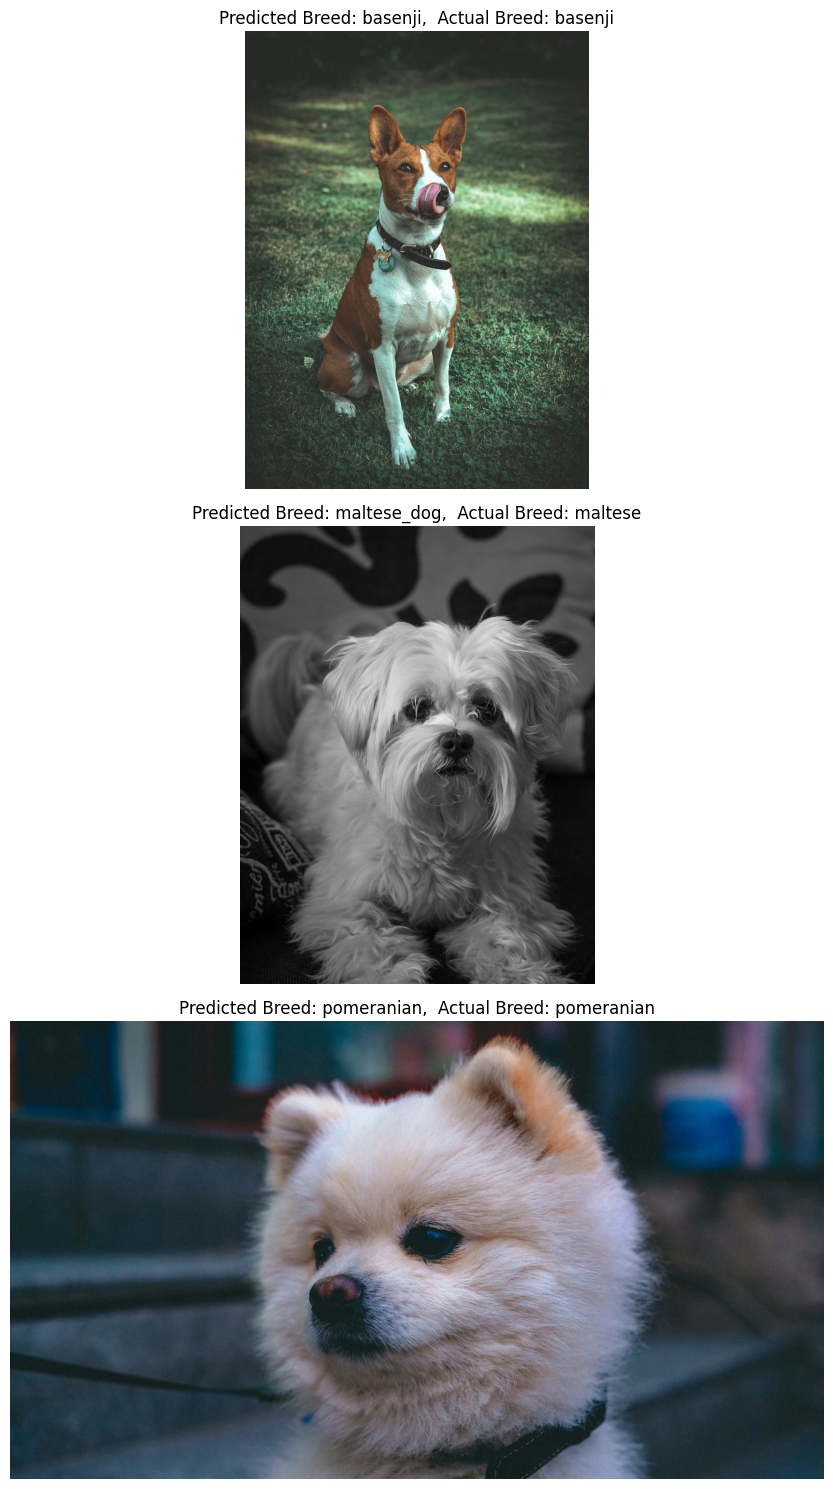

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

def load_original_image(img_path):
    img = image.load_img(img_path)
    return img

def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img, img_array
target_size = (128, 128)

image_paths = [
    '/kaggle/input/dogs-breed/basenji.jpg',
    '/kaggle/input/dogs-breed/maltese.jpg',
    '/kaggle/input/dogs-breed/pomeranian.jpg'
]


actual_breeds = ['basenji', 'maltese', 'pomeranian']

class_indices = train_generator.class_indices
class_indices = {v: k for k, v in class_indices.items()}  

plt.figure(figsize=(10, 5 * len(image_paths)))

for i, (img_path, actual_breed) in enumerate(zip(image_paths, actual_breeds), 1):
    original_img = load_original_image(img_path)
    img, img_array = preprocess_image(img_path, target_size)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_breed = class_indices[predicted_class]
    plt.subplot(len(image_paths), 1, i)
    plt.imshow(original_img)
    plt.title(f'Predicted Breed: {predicted_breed},  Actual Breed: {actual_breed}')
    plt.axis('off')

plt.tight_layout()
plt.show()
